[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial7.ipynb)   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial7.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# **Tutorial 7: Other Computational Tools in Xarray**

**Week 1, Day 1, Climate System Overview**

**Content creators:** Sloane Garelick, Julia Kent

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google Deepmind

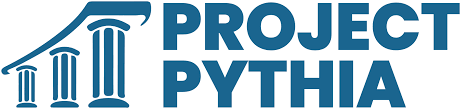 | 
-
Pythia credit: Rose, B. E. J., Kent, J., Tyle, K., Clyne, J., Banihirwe, A., Camron, D., May, R., Grover, M., Ford, R. R., Paul, K., Morley, J., Eroglu, O., Kailyn, L., & Zacharias, A. (2023). Pythia Foundations (Version v2023.05.01) https://zenodo.org/record/8065851



# **Tutorial Objectives**
Thus far, we've learned about various climate processes in the videos, and we've explored tools in Xarray that are useful for analyzing and interpreting climate data. 

In this tutorial you'll continue using the SST data from CESM2 and practice using some additional computational tools in Xarray to resample your data, which can help with data comparison and analysis. The functions you will use are:

- `resample`: Groupby-like functionality specifically for time dimensions. Can be used for temporal upsampling and downsampling. Additional information about resampling in Xarray can be found [here](https://xarray.pydata.org/en/stable/user-guide/time-series.html#resampling-and-grouped-operations).
- `rolling`: Useful for computing aggregations on moving windows of your dataset e.g. computing moving averages. Additional information about resampling in Xarray can be found [here](https://xarray.pydata.org/en/stable/user-guide/computation.html#rolling-window-operations).
- `coarsen`: Generic functionality for downsampling data. Additional information about resampling in Xarray can be found [here](https://xarray.pydata.org/en/stable/user-guide/computation.html#coarsen-large-arrays).

# **Setup**


In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pythia_datasets import DATASETS
import pandas as pd
import matplotlib.pyplot as plt

##  Figure Settings


###  Figure Settings


####  Figure Settings


#####  Figure Settings


In [ ]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

##  Video 1: Video Title


###  Video 1: Video Title


####  Video 1: Video Title


#####  Video 1: Video Title


In [ ]:
# @title Video 1: Video Title
#Tech team will add code to format and display the video

# **Section 1: High-level Computation Functionality**

In this tutorial you will learn about several methods for dealing with the resolution of data. Here are some links for quick reference, and we will go into detail in each of them in the sections below.

- `resample`: [Groupby-like functionality specifialized for time dimensions. Can be used for temporal upsampling and downsampling](https://xarray.pydata.org/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
- `rolling`: [Useful for computing aggregations on moving windows of your dataset e.g. computing moving averages](https://xarray.pydata.org/en/stable/user-guide/computation.html#rolling-window-operations)
- `coarsen`: [Generic functionality for downsampling data](https://xarray.pydata.org/en/stable/user-guide/computation.html#coarsen-large-arrays)

First, let's load the same data that we used in the previous tutorial (monthly SST data from CESM2):

In [ ]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
ds = xr.open_dataset(filepath)
ds

## **Section 1.1: Resampling Data**

For upsampling or downsampling temporal resolutions, we can use the `resample()` method in Xarray.  For example, you can use this function to downsample a dataset from hourly to 6-hourly resolution.

Our original SST data is monthly resolution. Let's use `resample()` to downsample to annual frequency:

In [ ]:
# resample from a monthly to an annual frequency
tos_yearly = ds.tos.resample(time='AS')
tos_yearly

In [ ]:
# calculate the global mean of the resampled data
annual_mean = tos_yearly.mean()
annual_mean_global = annual_mean.mean(dim=['lat', 'lon'])
annual_mean_global.plot()


## **Section 1.2: Moving Average**

The `rolling()` method allows for a rolling window aggregation and is applied along one dimension using the name of the dimension as a key (e.g. time) and the window size as the value (e.g. 6). We will use these values in the demonstration below.

Let's use the `rolling()` function to compute a 6-month moving average of our SST data:

In [ ]:
# calculate the running mean
tos_m_avg = ds.tos.rolling(time=6, center=True).mean()
tos_m_avg

In [ ]:
# calculate the global average of the running mean
tos_m_avg_global = tos_m_avg.mean(dim=['lat','lon'])
tos_m_avg_global.plot()


## **Section 1.3: Coarsening the Data**

The `coarsen()` function allows for block aggregation along multiple dimensions. 

Let's use the `coarsen()` function to take a block mean for every 4 months and globally (i.e., 180 points along the latitude dimension and 360 points along the longitude dimension). Although we know the dimensions of our data quite well, we will include code that finds the length of the latitude and longitude variables so that it could work for other datasets that had a different format.

In [ ]:
# coarsen the data
coarse_data = ds.coarsen(time=4,lat=len(ds.lat),lon=len(ds.lon)).mean()
coarse_data

In [ ]:
coarse_data.tos.plot()

## **Section 1.4: Compare the Resampling Methods**

Now that we've tried multiple resampling methods on different temporal resolutions, we can compare the resampled datasets to the original.

In [ ]:
original_global = ds.mean(dim=['lat', 'lon'])

In [ ]:
original_global.tos.plot(size=6)
coarse_data.tos.plot()
tos_m_avg_global.plot()
annual_mean_global.plot()


plt.legend(['original data (monthly)','coarsened (4 months)','moving average (6 months)', 'annually resampled (12 months)']);

### **Questions 1.4: Climate Connection**

1. What type of information can you obtain from each time series?
2. In what scenarios would you use different temporal resolutions?


[*Click for solution*](https://github.com/ClimateMatchAcademy/course-content/tree/main/tutorials/W1D1_ClimateSystemOverview/solutions/W1D1_Tutorial7_Solution_61f41a03.py)



# **Summary**

In this tutorial, we've explored Xarray tools to simplify and understand climate data better. Given the complexity and variability of climate data, tools like `resample`, `rolling`, and `coarsen` come in handy to make the data easier to compare and find long-term trends. You've also looked at valuable techniques like calculating moving averages. 





# **Resources**

Code and data for this tutorial is based on existing content from [Project Pythia](https://foundations.projectpythia.org/core/xarray/computation-masking.html).